## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import os
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from tqdm import tqdm
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score
import glob
import random
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Set the seed

In [2]:
# Set random seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

## Define train and test data path

In [3]:
train = ('/kaggle/input/brain-tumor-classification-mri/Training/')
test = ('/kaggle/input/brain-tumor-classification-mri/Testing/')

## Transform the images

In [4]:
transforming_img = transforms.Compose([
    transforms.Resize((150,150)), #resize the image 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # convert image to tensors
    transforms.Normalize([0.5,0.5,0.5], #mean
                        [0.5,0.5,0.5]) #standard deviation
])

## Load the data 

In [5]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train,transform=transforming_img),
    batch_size=64, shuffle=True #64
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test,transform=transforming_img),
    batch_size=32, shuffle=True #32
)

## Visualize the images 

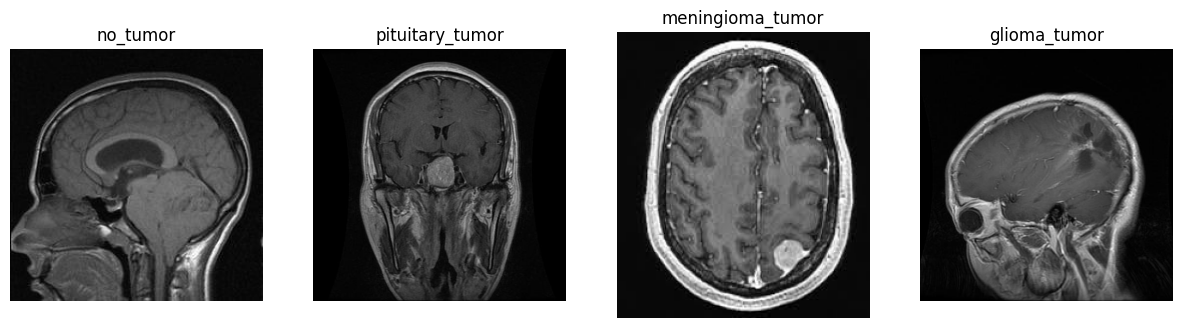

In [6]:
# Get a list of folders within train_path
list_name = [d for d in os.listdir(train) if os.path.isdir(os.path.join(train, d))]

# Create a figure with subplots, one for each folder
fig, axes = plt.subplots(1, len(list_name), figsize=(15, 5))

for i, dirname in enumerate(list_name):
    image_files = [f for f in os.listdir(os.path.join(train, dirname)) if f.endswith(".jpg")]
    
    # Select the first image from the list
    image_path = os.path.join(train, dirname, image_files[0])
    
    # Open and display the image using PIL
    img = Image.open(image_path)
    
    # Display the image in the corresponding subplot
    axes[i].imshow(img)
    axes[i].set_title(dirname)
    axes[i].axis('off')

plt.show()

## Check how many images in train and test files

In [7]:
train_count=len(glob.glob(train+'/**/*.jpg'))
test_count=len(glob.glob(test+'/**/*.jpg'))

In [8]:
train_count

2870

In [9]:
test_count

394

In [9]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Model

In [10]:
class TumorNet(nn.Module):
    def __init__(self, num_classes=4):
        super(TumorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        
        self.fc = nn.Linear(in_features=64 * 75 * 75, out_features=num_classes)
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)
        
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        
        output = output.view(-1, 64 * 75 * 75)
        output = self.fc(output)
        
        return output


model=TumorNet(num_classes=4).to(device)

##  load mini-batches of training data

In [11]:
for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available(): #check if GPU available
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

## Set the optimizer and the loss function

In [12]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

## Training

In [13]:
best_accuracy=0.0

for epoch in range(20):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(13.3003) Train Accuracy: 0.616376306620209 Test Accuracy: 0.3883248730964467
Epoch: 1 Train Loss: tensor(4.5430) Train Accuracy: 0.7519163763066202 Test Accuracy: 0.5456852791878173
Epoch: 2 Train Loss: tensor(2.9221) Train Accuracy: 0.8209059233449477 Test Accuracy: 0.616751269035533
Epoch: 3 Train Loss: tensor(1.5602) Train Accuracy: 0.8686411149825783 Test Accuracy: 0.6700507614213198
Epoch: 4 Train Loss: tensor(0.7475) Train Accuracy: 0.9226480836236933 Test Accuracy: 0.7081218274111675
Epoch: 5 Train Loss: tensor(0.5824) Train Accuracy: 0.9421602787456446 Test Accuracy: 0.6522842639593909
Epoch: 6 Train Loss: tensor(1.2254) Train Accuracy: 0.9045296167247386 Test Accuracy: 0.700507614213198
Epoch: 7 Train Loss: tensor(0.7058) Train Accuracy: 0.9341463414634147 Test Accuracy: 0.6852791878172588
Epoch: 8 Train Loss: tensor(0.3813) Train Accuracy: 0.9609756097560975 Test Accuracy: 0.6776649746192893
Epoch: 9 Train Loss: tensor(0.5095) Train Accuracy: 0.955